<a href="https://www.kaggle.com/code/mkubina/hate-comments-detection-and-classification?scriptVersionId=218968416" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [195]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-csv/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [196]:
data = pd.read_csv("/kaggle/input/train-csv/train.csv")
data.head(10)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
5             0        0       0       0              0  
6             1        1       0       1              0  
7             0        0       0       0              0  
8             0        0       0       0              0  
9             0        0       0       0              0

In [197]:
data.shape

(159571, 8)

In [198]:
print(data.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [199]:
for harm in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(harm + ":")
    print(data.comment_text[data[harm] == 1].values[42] + "\n")

print("vanilla:")
print(data.comment_text.values[1] + "\n")

toxic:
Gay 

The existence of CDVF is further proof that  is a sad twat. He is also very ugly, and has a willy for a face.

severe_toxic:
You Are a fuck head I'm not a vandal so suck cock ass master.  We'll talk after your done with your Mom.

obscene:
Groin 

You sad fuck. I'm going to restore my edit, and you are going to leave it, or else I wil knee you in the groin yourself, prick. 91.108.208.101

threat:
You fucking chink, i hope you die of cancer like your grandmother did. fucking jack off, get the fuck off the internet.

insult:
I shit on your face 

fuck you

identity_hate:
Are you a faggot or what?

vanilla:
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)



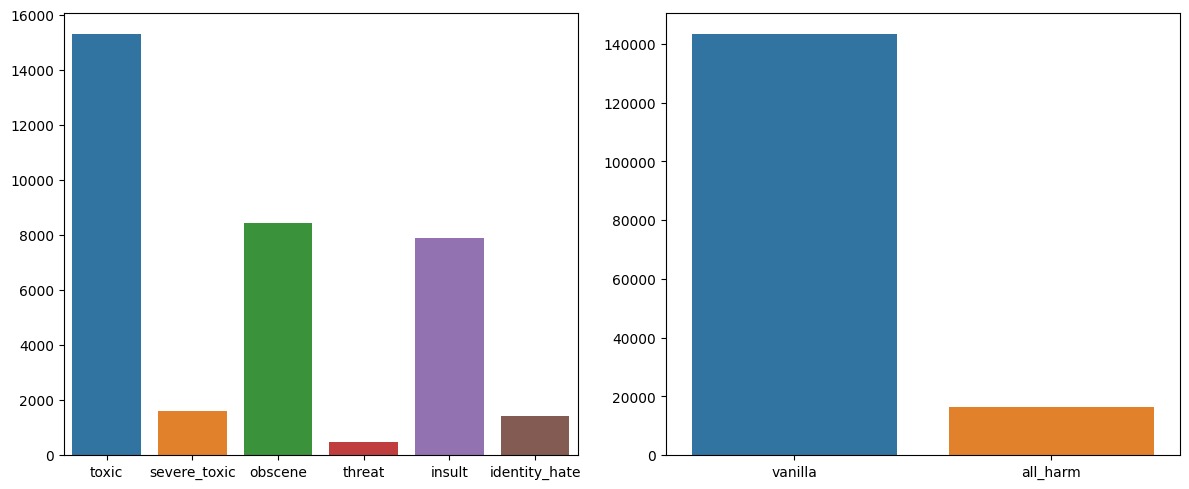

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

freq_harms = {}
for harm in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    freq_harms[harm] = len(data[data[harm] == 1])

freq_isharm = {}
vanilla_mask = (data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 0).all(axis=1)
freq_isharm['vanilla'] = len(data[vanilla_mask])
freq_isharm['all_harm'] = len(data) - len(data[vanilla_mask])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=np.array(list(freq_harms.keys())), y=np.array(list(freq_harms.values())), ax=ax1)
sns.barplot(x=np.array(list(freq_isharm.keys())), y=np.array(list(freq_isharm.values())), ax=ax2)

plt.tight_layout()
plt.show()

In [201]:
data['vanilla_mask'] = vanilla_mask.astype(int)
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'vanilla_mask'],
      dtype='object')

It seems wise to detect harmful comments from the vanilla ones in binary classification (logistic regression, maybe), and only then get more granular on classify along harm types.

In [202]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

def clean_words(tokens):
	stops = stopwords.words('english')
	clean_tokens = [token.lower().strip() for token in tokens if token.lower() not in stops and token.isalnum()]

	return clean_tokens

new_len = int(np.round(len(data)*0.1))
data_sample = data.iloc[0:new_len].copy()

data_sample['tokens'] = data_sample['comment_text'].apply(lambda x: word_tokenize(x))
data_sample['tokens'] = data_sample['tokens'].apply(lambda x: clean_words(x))
data_sample[['comment_text', 'tokens']].head

<bound method NDFrame.head of                                             comment_text  \
0      Explanation\nWhy the edits made under my usern...   
1      D'aww! He matches this background colour I'm s...   
2      Hey man, I'm really not trying to edit war. It...   
3      "\nMore\nI can't make any real suggestions on ...   
4      You, sir, are my hero. Any chance you remember...   
...                                                  ...   
15952  Tags\n\nThose tags are horrid. Please, someone...   
15953  Congratulations \n\nYou're now an admin. Use t...   
15954  I've seen discussions on the internet that men...   
15955  Hi, the recent edit you made to Wikipedia:Arti...   
15956  Wow, what an incredible douchebag, I love the ...   

                                                  tokens  
0      [explanation, edits, made, username, hardcore,...  
1      [matches, background, colour, seemingly, stuck...  
2      [hey, man, really, trying, edit, war, guy, con...  
3      [ca, m

In [203]:
harm_corpus = []
vanilla_corpus = []

for comment in data_sample['tokens'][data['vanilla_mask'] != 1]:
    for token in comment:
        harm_corpus.append(token)

for comment in data_sample['tokens'][data['vanilla_mask'] == 1]:
    for token in comment:
        vanilla_corpus.append(token)

print(harm_corpus[:50])
print()
print(vanilla_corpus[:50])

['cocksucker', 'piss', 'around', 'work', 'hey', 'talk', 'exclusive', 'group', 'wp', 'talibans', 'good', 'destroying', 'purist', 'gang', 'one', 'asks', 'questions', 'abt', 'destructive', 'non', 'wp', 'ask', 'sityush', 'clean', 'behavior', 'issue', 'nonsensical', 'warnings', 'bye', 'look', 'come', 'think', 'comming', 'back', 'tosser', 'gay', 'antisemmitian', 'archangel', 'white', 'tiger', 'meow', 'greetingshhh', 'uh', 'two', 'ways', 'erased', 'comment', 'ww2', 'holocaust', 'brutally']

['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalisms', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'please', 'remove', 'template', 'talk', 'page', 'since', 'retired', 'matches', 'background', 'colour', 'seemingly', 'stuck', 'thanks', 'talk', 'january', '11', '2016', 'utc', 'hey', 'man', 'really', 'trying', 'edit', 'war', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking', 'edits', 'instead', 'talk', 'page']


In [204]:
from collections import Counter

print("Top Words in harm comments:", Counter(harm_corpus).most_common(10))
print("\nTop Words in vanilla comments:", Counter(vanilla_corpus).most_common(10))

Top Words in harm comments: [('fuck', 1109), ('nigger', 1037), ('balls', 850), ('ass', 795), ('sex', 704), ('u', 685), ('hate', 595), ('go', 520), ('fucking', 500), ('cunt', 499)]

Top Words in vanilla comments: [('article', 5448), ('page', 4610), ('wikipedia', 4015), ('talk', 3277), ('would', 2923), ('please', 2769), ('one', 2701), ('like', 2342), ('see', 2140), ('also', 1960)]


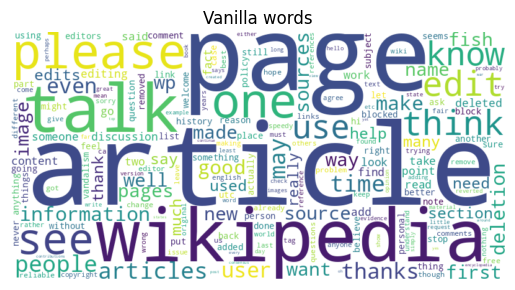

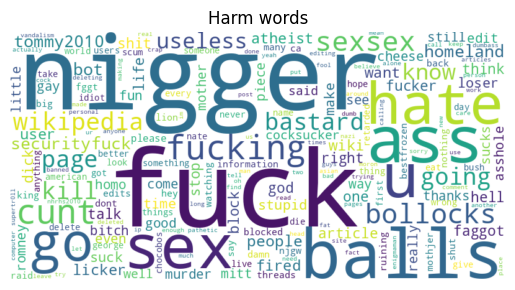

In [205]:
from wordcloud import WordCloud

def make_cloud(title, corpus):
    text = ' '.join(corpus)
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False,  # Disable bigram collocations
        normalize_plurals=False).generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

make_cloud('Vanilla words', vanilla_corpus)
make_cloud('Harm words', harm_corpus)

This looks pretty straithforward. We'll try applying logistic regression on classifying vanilla comments from harmful ones.

In [206]:
'''
for harm in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    corpus = []
    for comment in data_sample['tokens'][data[harm] == 1]:
        for token in comment:
            corpus.append(token)
    make_cloud(harm, corpus)
'''

"\nfor harm in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:\n    corpus = []\n    for comment in data_sample['tokens'][data[harm] == 1]:\n        for token in comment:\n            corpus.append(token)\n    make_cloud(harm, corpus)\n"

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X = data_sample["tokens"].apply(lambda tokens: ' '.join(tokens))
y = data_sample["vanilla_mask"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_valid_vectors = vectorizer.transform(X_valid)

In [208]:
model = LogisticRegression()

model.fit(X_train_vectors, y_train)
predictions = model.predict(X_valid_vectors)

score = accuracy_score(y_valid, predictions)
score_rec = recall_score(y_valid, predictions)
score_f = f1_score(y_valid, predictions)
score_prec = precision_score(y_valid, predictions)

print(score)
print(score_rec)
print(score_f)
print(score_prec)

0.9461152882205514
0.9886016124548235
0.9706564760474956
0.9533512064343164


In [209]:
def test_comment(comment):
    comment_vector = vectorizer.transform([comment])
    prediction = model.predict(comment_vector) 
    if prediction[0] == 0: 
        print("Harmful comment detected.")
    else:
        print("Comment is not harmful.")

test_comment("Nicey flowers everywhere!")
test_comment("Gonna kick your ass, motherfucker!")
test_comment("Gonna kick your ass")

Comment is not harmful.
Harmful comment detected.
Comment is not harmful.
